In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1
p["errorbar.capsize"] = 2


In [3]:
headers = []
datas = []
for run in glob('../data/temperature_grill/*'):
    header = np.loadtxt(run, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    headers.append(header)

    data = np.loadtxt(run, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append((V_in_combined, I_out_combined, I_out_std_combined))

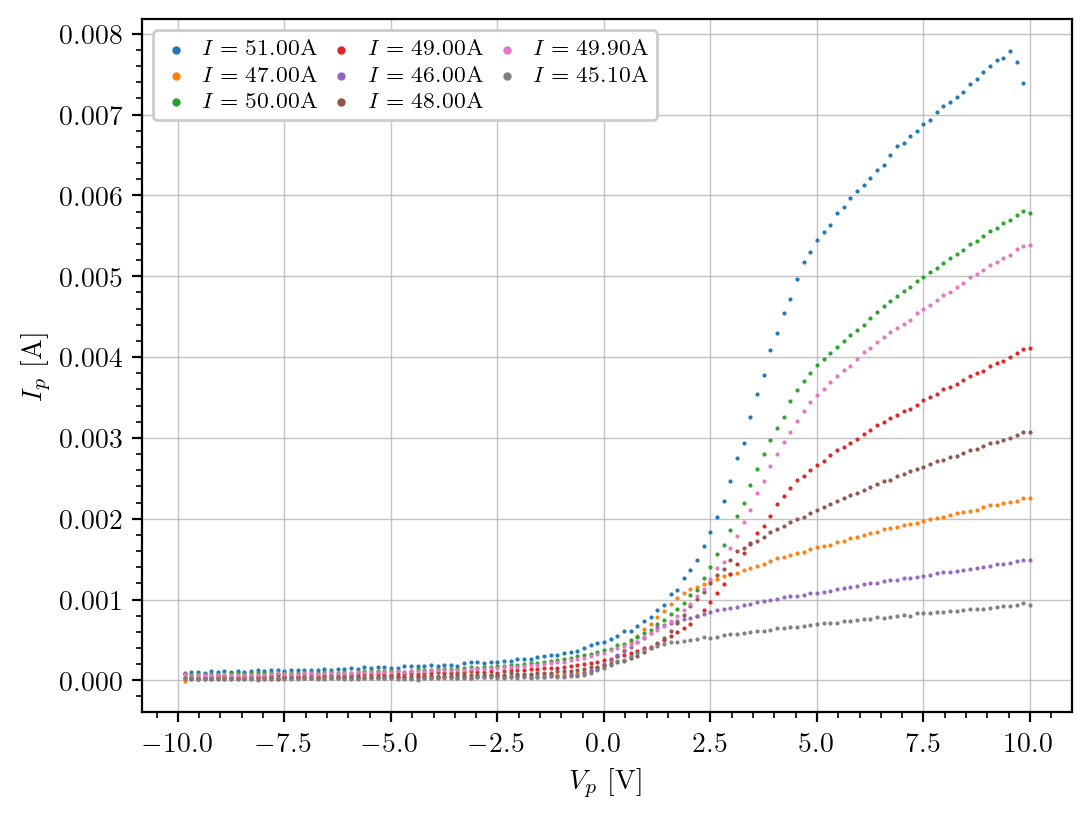

In [4]:
fig, ax = plt.subplots(1,1, dpi=200)
colors = list(plt.cm.tab10(np.arange(10))) + ["steelblue", "indigo", "darkgoldenrod", "seagreen", "orangered"]
ax.set_prop_cycle('color', colors)
plt.xlabel("$V_p$ [V]")
plt.ylabel("$I_p$ [A]")
for header, data in zip(headers, datas):
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    V_in, I_out, I_out_std = data

    plt.scatter(V_in, (I_out), label=f"$I = {I_chauffage:.2f}$A")
    idx = I_out < 0
    # plt.scatter(V_in[idx], I_out[idx])
    plt.legend(ncols=3, fontsize=8, markerscale=4, loc="upper left", columnspacing=0.5)

## Find V_{sp}, ln(I_{es})

In [5]:
def set_all_between(arr):
    idx = np.nonzero(arr)[0]
    idx_start, idx_stop = idx[0], idx[-1]
    arr[idx_start:idx_stop+1] = True
    return arr

In [6]:
T_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
T = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
n_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))

B_fit_stop = [1, 0.1, 1.5, 4, 3, 3.5, 4, 4]
C_fit_start = [2, 3, 3, 4, 5, 5, 5, 5]

for i, (header, data) in enumerate(zip(headers, datas)):
    print(f"Fit {i}")
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    V_in, I_out, I_out_std = data

    dydx = np.gradient(np.nan_to_num(np.log(I_out), nan=1), V_in)
    threshold = 7e-2
    idx = np.abs(np.diff(dydx, prepend=0)) < threshold
    if(I_chauffage == 46): # le deuxième fit (run 69) a besoin de commencer avant
        print("FOUND")
        idx = np.logical_and(idx, V_in > -1)
    else:
        idx = np.logical_and(idx, V_in > -0.5)
    # print("Voltage in fit, general")
    # print(V_in[idx])
    idx_B = set_all_between(np.logical_and(idx, V_in < B_fit_stop[i]))
    idx_C = set_all_between(np.logical_and(idx, V_in > C_fit_start[i]))
    # idx_B = np.logical_and(0 < V_in, V_in < 3)
    # idx_C = V_in > 6
    # print("Voltage_in fit B")
    # print(V_in[idx_B])
    coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
    coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
    fitfuncB = np.poly1d(coefsB)
    coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
    coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
    fitfuncC = np.poly1d(coefsC)

    x = np.linspace(V_in[0], V_in[-1])
    plt.scatter(V_in, np.log(I_out), c='k', label=f"$I_c = {header[5]}")
    plt.plot(x, fitfuncB(x))
    plt.plot(x, fitfuncC(x))

    V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
    I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
    print(V_sp, I_sp)
    plt.axvline(V_sp.n)
    plt.axhline(umath.log(I_sp).n)

    T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
    T_e_run += ufloat(0, 0.4e3)
    T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
    # TODO: verifier unitées
    n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
    print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
    T_e[i] = T_e_run
    T[i] = T_run
    n_e[i] = n_e_run

    plt.gcf().delaxes(plt.gca())
    # plt.xlabel("$V_p$ [V]")
    # plt.ylabel("$I_p$ [A]")
    # plt.legend()
    # plt.show()

Fit 0
5.1+/-0.7 0.0044+/-0.0008
T_e_run = (2.6±0.2)×10⁴, T_run = (2.3±0.2)×10⁰, n_e_run = (3.5±0.6)×10¹⁶
Fit 1


/tmp/ipykernel_24431/3894678241.py:13: RuntimeWarning: invalid value encountered in log
  dydx = np.gradient(np.nan_to_num(np.log(I_out), nan=1), V_in)
/tmp/ipykernel_24431/3894678241.py:29: RankWarning: Polyfit may be poorly conditioned
  coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)


LinAlgError: Singular matrix

<Figure size 780x585 with 0 Axes>

In [ ]:
currents = list(map(lambda header: header[5], headers))

In [ ]:
p = plt.rcParams
p["figure.figsize"] = (5.75*CM_PER_INCH, 4.5*CM_PER_INCH)
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.21
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.9
p['figure.subplot.bottom'] = 0.22

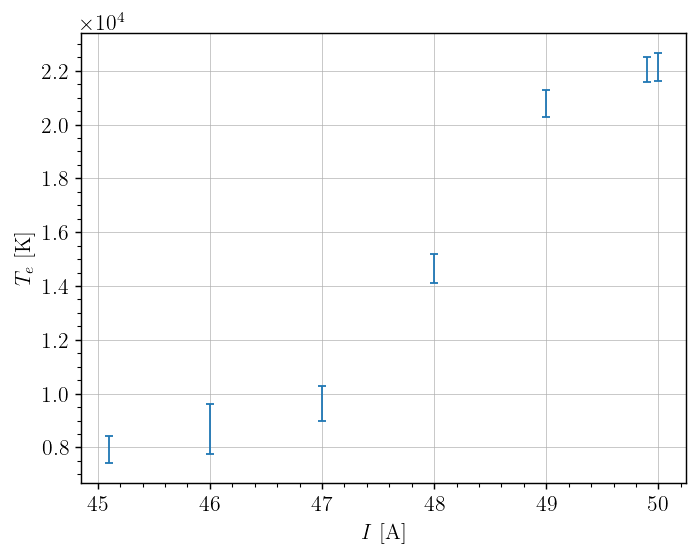

In [ ]:
plt.ticklabel_format(axis='both', style='scientific', scilimits=(-3,3))

plt.errorbar(currents[:-1], nom_vals(T_e)[:-1], yerr=std_devs(T_e)[:-1], ls='')
plt.xlabel(r'$I$ [A]')
plt.ylabel(r'$T_e$ [K]')
plt.savefig("../figures/temperatureK_current.pdf")

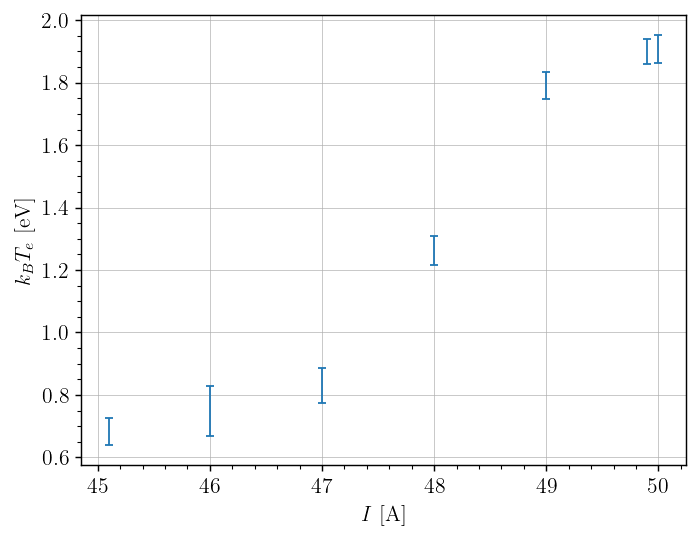

In [ ]:
plt.errorbar(currents[:-1], nom_vals(T)[:-1], yerr=std_devs(T)[:-1], ls='')
plt.xlabel(r'$I$ [A]')
plt.ylabel(r'$k_B T_e$ [eV]')
plt.savefig("../figures/temperatureeV_current.pdf")

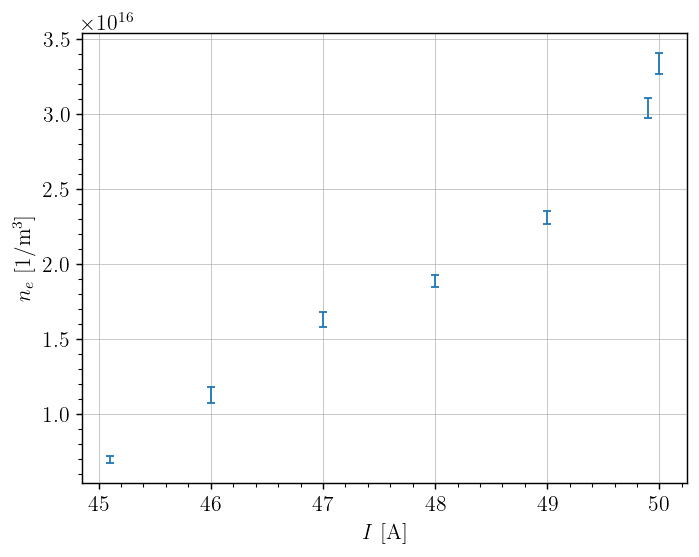

In [ ]:
plt.errorbar(currents[:-1], nom_vals(n_e)[:-1], yerr=std_devs(n_e)[:-1], ls='')
plt.xlabel(r'$I$ [A]')
plt.ylabel(r'$n_e$ $[1/$m$^3]$')
plt.savefig("../figures/density_current.pdf")